In [1]:
from datetime import datetime

In [2]:
year=2024

In [3]:
def import_names_from_file(file_path):
    names_list = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Supprimer les espaces ou les sauts de ligne
                name = line.strip()
                if name:  # Ajouter uniquement les lignes non vides
                    names_list.append(name)
    except FileNotFoundError:
        print(f"Le fichier {file_path} n'a pas été trouvé.")
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

    return names_list

# Exemple d'utilisation
file_path = 'data_2024/catalog.txt'
names = import_names_from_file(file_path)

## geotiff_to_csv_with_coords

Function to convert a given geotiff into a pandas DataFrame. DataFrame contains (x,y) coordinates of each points.

In [4]:
import rasterio
import pandas as pd
import numpy as np

def geotiff_to_csv_with_coords(geotiff_path, csv_path=None):
    # Ouvrir le fichier GeoTIFF
    with rasterio.open(geotiff_path) as src:
        # Lire toutes les bandes
        bands = [src.read(i) for i in range(1, src.count + 1)]

        # Obtenir la transformation affine
        transform = src.transform

        # Créer des grilles de coordonnées
        cols, rows = np.meshgrid(np.arange(src.width), np.arange(src.height))

        # Calculer les coordonnées (x, y) pour chaque pixel
        xs, ys = rasterio.transform.xy(transform, rows, cols)

        # Créer un DataFrame pour stocker les données
        data = {'X': xs.flatten(), 'Y': ys.flatten()}
        for i, band in enumerate(bands, start=1):
            # Aplatir la bande en une liste 1D
            data[f'Band_{i}'] = band.flatten()

        # Créer un DataFrame à partir des données
        df = pd.DataFrame(data)

        # Enregistrer le DataFrame en CSV
        #df.to_csv(csv_path, index=False)

        return(df)

## Compute aggregates for CLC comparison

Compute lower-left (x_rounded,y_rounded) coordinates of Corine hectares (Corine pixels are 100m*100m).
We have (x_rounded,y_rounded)=( (x//100)*100 , (y//100)*100 ).

In [5]:
def aggregate(df,filename):
    # Arrondir les coordonnées à 100 unités près
    df['X_rounded'] = (df['X'] // 100) * 100
    df['Y_rounded'] = (df['Y'] // 100) * 100
    
    # Grouper par les coordonnées arrondies et calculer les statistiques
    agg_stats = df.groupby(['X_rounded', 'Y_rounded']).agg(
        Band_1_min=pd.NamedAgg(column='Band_1', aggfunc='min'),
        Band_1_q1=pd.NamedAgg(column='Band_1', aggfunc=lambda x: x.quantile(0.25)),
        Band_1_median=pd.NamedAgg(column='Band_1', aggfunc='median'),
        Band_1_q3=pd.NamedAgg(column='Band_1', aggfunc=lambda x: x.quantile(0.75)),
        Band_1_max=pd.NamedAgg(column='Band_1', aggfunc='max')
    )
    
    # Répéter pour chaque bande
    #for band in df.columns[2:]:  # Supposons que les bandes commencent à l'index 2
    for band in set(df.columns[2:]).difference(set(['X_rounded','Y_rounded','Band_1'])):
        stats = df.groupby(['X_rounded', 'Y_rounded'])[band].agg(
            min='min',
            q1=lambda x: x.quantile(0.25),
            median='median',
            q3=lambda x: x.quantile(0.75),
            max='max'
        ).add_prefix(f'{band}_')
    
        # Ajouter les statistiques au DataFrame agrégé
        agg_stats = pd.concat([agg_stats, stats], axis=1)
    
    # Réinitialiser l'index pour obtenir un DataFrame propre
    agg_stats = agg_stats.reset_index()

    identifier=filename.split('/')[1]
    agg_stats.to_parquet(f'parquet/{identifier}_{year}.parquet')

    return(agg_stats)


In [6]:
for name in names:
    print(f'{datetime.now()} - Processing of {name}')
    df=geotiff_to_csv_with_coords(name)
    aggregate(df,name)
    

2025-03-09 06:03:42.232084 - Processing of data_2024/039a5cbf4331d6c52e731f5af3a7d2fc/response.tiff
2025-03-09 06:05:02.582871 - Processing of data_2024/0977c1842c1b3ab90233746f2f57b884/response.tiff
2025-03-09 06:06:21.442235 - Processing of data_2024/0a324c15f78eaca86f79dfc8111d84d2/response.tiff
2025-03-09 06:07:42.469780 - Processing of data_2024/0a54fbd049e2d600cbaba418a0f981eb/response.tiff
2025-03-09 06:09:01.779782 - Processing of data_2024/0e24bef27d476993641529238abafb5d/response.tiff
2025-03-09 06:10:21.156413 - Processing of data_2024/0efa25d60700eef8b6a4879783fbab11/response.tiff
2025-03-09 06:11:41.614578 - Processing of data_2024/0f19022559b7dfb68d82a4c4ad79d38a/response.tiff
2025-03-09 06:13:02.265321 - Processing of data_2024/101c1e802b6b9fbf5c28ae0ee16e5bd5/response.tiff
2025-03-09 06:14:22.095027 - Processing of data_2024/12e0713d088935d958a05dcc83d6b78b/response.tiff
2025-03-09 06:15:44.283372 - Processing of data_2024/13268f30d4154417bacb884396ff6ee4/response.tiff


## Example of visualisation that represents the aggregation

### Orginal (NDVI)

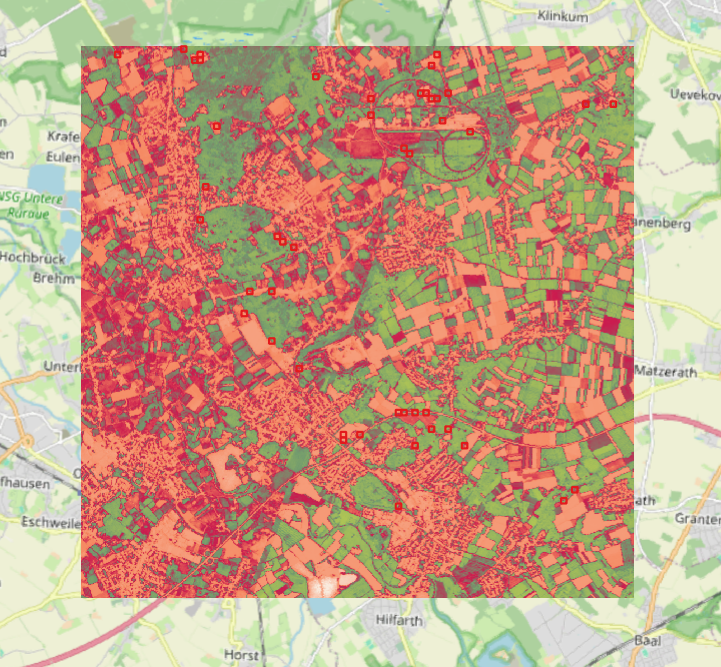

### Aggregate (NDVI Band_7_median)

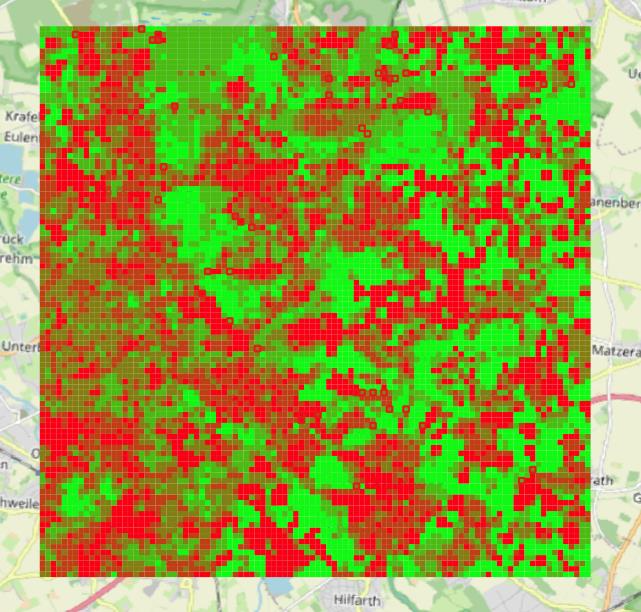